## Importance Sampling and Particle filter

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import poisson

## Importance Sampling and resampling

Before we dive into the vast universe of nonlinear filtering, let us take a step back and review importance sampling. The idea of importance is to empirically approximate a probability distribution, which we can evaluate but cannot directly sample from, by weighted samples from _another_ probability distribution. 
As an example, let us consider a mysterious parabola-shaped probability function $p(x) =  3/4 * (1-x^2) $, defined on $x $ in $ [-1,1]$. We cannot sample from this distribution, but we can sample from the uniform distribution between -1 and 1. Let us now generate weighted samples to approximate the parabola distribution (algorithm 2)

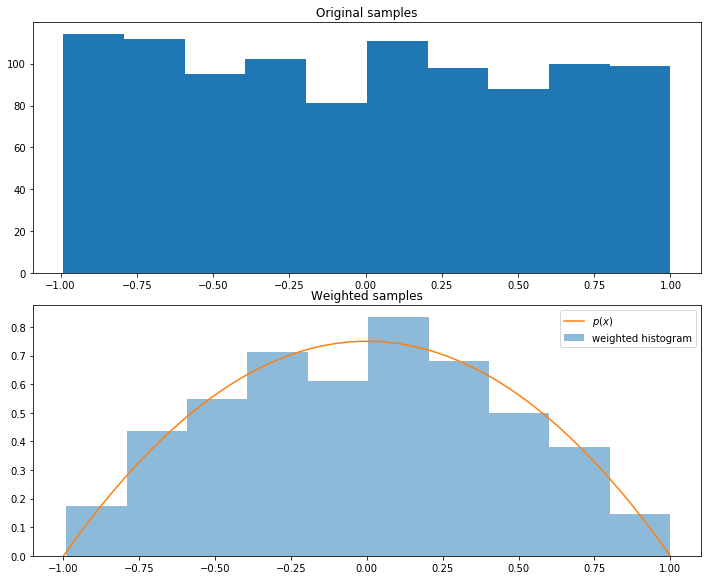

In [18]:
# Approximate beta distribution with weighted samples from the uniform distribution
np.random.seed(42)

N = 1000

# draw samples from proposal
x = np.random.uniform(-1,1,N)

# compute weights
p = lambda x: 3/4*(- x**2 +1)
w = p(x)

# normalize the weights such that they sum to 1
w = w/np.sum(w)

# histogram of original samples
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
fig.tight_layout()
ax1.hist(x)
ax1.set_title('Original samples')

# histogram of weighted samples, together with probability distribution
bins = np.linspace(-1, 1, int(np.sqrt(N)))
ax2.hist(x,weights=w,density = True,alpha=0.5)
xaxis = np.linspace(-1,1,50)
ax2.plot(xaxis,p(xaxis))
ax2.legend([r'$p(x)$','weighted histogram'])
ax2.set_title('Weighted samples')

plt.show()


Assume you don't want to store the weights for some reason, but want to have samples that represent the parabola distribution. In this case, you can use the resampling algorithm (algorithm 4) to generate equally weighted samples from the weight distribution:

In [19]:
def resample(x,w,N):
    x_r = np.random.choice(x,N,p=w)
    w_r = 1/N * np.ones(w.shape)
    return x_r,w_r

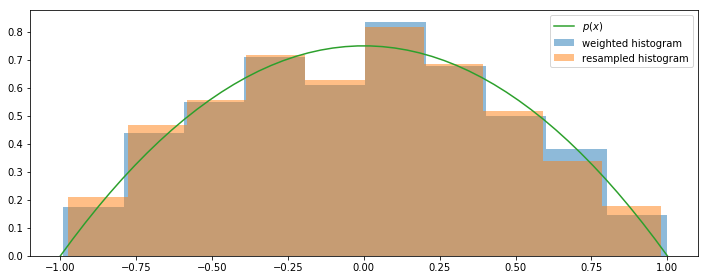

In [20]:
#resample to produce equally weighted samples, which is equivalent to samples without the need for a weight
x_r,_ = resample(x,w,N)

# histogram of original samples
fig, ax2 = plt.subplots(1,1,figsize=(10,4))
fig.tight_layout()

# histogram of weighted samples
bins = np.linspace(-1, 1, int(np.sqrt(N)))
ax2.hist(x,weights=w,density = True,alpha=0.5)
ax2.hist(x_r,density = True,alpha=0.5)
xaxis = np.linspace(-1,1,50)
ax2.plot(xaxis,p(xaxis))
ax2.legend([r'$p(x)$','weighted histogram','resampled histogram'])


plt.show()

Note that even though the idea of resampling is intruguingly simple, it will increase the variance of the samples.

## Getting started with particle filters: Revisit the random walk
In order to compare the PF (and to benchmark it), let us use it on the simple random walk model that we have encountered in the KF section. We already have an optimal solution to this problem (the Kalman filter), and we will now compare the PF to this.

In [5]:
def KF1D_generateData(params):
    
    x = np.zeros(params["T"]+1)
    y = np.zeros(params["T"]+1)
    
    # initialization
    x[0] = np.random.normal(params["mu0"],np.sqrt(params["Sigma0"]))
    y[0] = np.random.normal(params["H"] * x[0], np.sqrt(params["R"]))
    
    for i in range(1,params["T"]+1):
        x[i] = np.random.normal(params["F"] * x[i-1],np.sqrt(params["Q"]))
        y[i] = np.random.normal(params["H"] * x[i], np.sqrt(params["R"]))
    
    
    return x, y

In [6]:
def KF1D(y,params):
    
    # unpack some parameters for readibility
    H = params["H"]
    F = params["F"]
    
    
    # initialize mu and Sigma
    mu = params["mu0"] * np.ones(params["T"]+1)
    Sigma = params["Sigma0"] * np.ones(params["T"]+1)    
    
    for i in range(1,params["T"]+1):
        
        # variance of prediction density
        if i == 1:
            P = params["Sigma0"] # for first step, P = Sigma0
        else:
            P = F * Sigma[i-1] * F + params["Q"]
            
        # Kalman gain
        K = P * H * (H * P * H + params["R"])**(-1)
        
        # propagate mean and variance
        mu[i] = F * mu[i-1] + K * (y[i] - H * F * mu[i-1])
        Sigma[i] = (1 - K * H ) * P
            
    
    return mu, Sigma

In [7]:
np.random.seed(42)

N = 2000
c = 0.5

params = {
    "F": 1,
    "Q": 1,
    "H": 1,
    "R": 10,
    "mu0": 10,
    "Sigma0": 2,
    "T": 100
}

# generate the data
x, y = KF1D_generateData(params)

# compute the KF estimate
mu, Sigma = KF1D(y,params)

Let's code up the Boostrap Particle filter (Algorithm 5). You may use the resampling procedure that you have already defined above.

In [8]:
def BootstrapPF(y,N,c,params):
    
    # initialization
    x = np.zeros([params["T"]+1,N])
    x[0] = np.random.normal(params["mu0"],np.sqrt(params["Sigma0"]),N)
    w = np.zeros([params["T"]+1,N])
    w[0] = 1/N
    
    # filtering recursion
    for t in range(1,params["T"]+1):
        # draw from proposal (transition density)
        x[t] = np.random.normal(params["F"]*x[t-1],np.sqrt(params["Q"]),N)
        #compute weights
        w[t] = w[t-1] * norm.pdf(y[t],params["H"]*x[t],np.sqrt(params["R"]))
        # normalize weights
        w[t] = w[t] / np.sum(w[t])
        
        # resample if necessary
        Neff = 1/np.sum(w[t]**2)
        if Neff < c * N:
            x[t],w[t] = resample(x[t],w[t],N)
    return x, w

In [9]:
np.random.seed(42)

# compute the Bootstrap PF estimate
x_PF,w_PF = BootstrapPF(y,N,c,params)

# compute mean and variance
mu_PF = np.sum(w_PF * x_PF,1)
Sigma_PF = np.sum(w_PF * ((x_PF.T-mu_PF)**2).T,1)

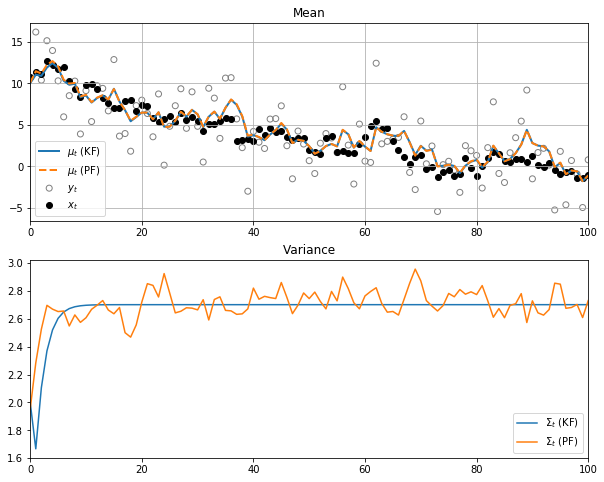

In [10]:
# Plot the trajectory and the observations
# (assume no observation at y = 0 )

t = np.arange(params["T"]+1)


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))

ax1.scatter(t[1:],y[1:],color='grey',facecolors='none')
ax1.scatter(t,x,color='black')
ax1.plot(t,mu,linewidth=2)
ax1.plot(t,mu_PF,'--',linewidth=2)
ax1.legend([r'$\mu_t$ (KF)',r'$\mu_t$ (PF)',r'$y_t$',r'$x_t$'])
ax1.grid(True)
ax1.set_xlim(0,params["T"])
ax1.set_title('Mean')

ax2.plot(t,Sigma)
ax2.plot(t,Sigma_PF)
ax2.set_xlim(0,params["T"])
ax2.set_title('Variance')
ax2.legend([r'$\Sigma_t$ (KF)',r'$\Sigma_t$ (PF)'])

plt.show()

## Nonlinear Gaussian models

Here, we consider a nonlinear filtering task, where the hidden state $X_t$ evolves according to a drift-diffusion with nonlinear drift function. Further, the observations $Y_t$ are linear and corrupted by Gaussian noise. Specifically, the generative model in terms of stochastic differential equations (SDE) reads:
\begin{eqnarray}
d X_t & = & \tilde{f}(X_t) \, dt + \sigma_x \, dW_t \\
d Z_t & = & \tilde{h}(X_t) \, dt + \sigma_y \, dV_t,
\end{eqnarray}
with $ \tilde{f}(x) = -4x(x^2-1) $ and $h(x) = x $.

Don't worry if you have never worked with SDE's before. It's actually nothing else than the dynamical system we looked at in the KF notebook, just written in a slightly weird way. Analogously, they can easily be discretized in time, and we can rewrite the model in terms of the following transition and emission probabilities:
\begin{eqnarray}
 p(x_t | x_{t-1} ) & = & \mathcal{N} ( x_t ; f(x_{t-1}), Q) \\
p(y_t | x_{t} ) & = & \mathcal{N} ( z_t ; h(x_{t}) , R),
\end{eqnarray}
with
\begin{eqnarray}
f(x) & = & x + \tilde{f}(x)  dt \\
Q & = & \sigma_x^2 dt \\
h(x)  & = & \tilde{h}(x) dt \\
R & = & \sigma_y^2 / dt.
\end{eqnarray}
The observations $y_t$ can be considered a temporal derivative of the process $Z_t$ (don't tell the mathematicians I said that). Note that again the observation variance scales inversely with the time step: The smaller I make the time step, the less informative a single observation becomes. On the other hand, I also have more observations per time, so this prevents oversampling my observations and thus making the inference trivial.

This is a nonlinear model, and we cannot use the Kalman filter anymore. In other words: Whatever the particle filter is doing, we have to trust it...

In [11]:
def NLGauss_generateData(params):
    
    # unpack some parameters for readibility
    f = params["f"]
    h = params["h"]
    
    x = np.zeros(params["T"]+1)
    y = np.zeros(params["T"]+1)
    
    # initialization (draw from Gauss with mean mu0 and variance Sigma0)
    x[0] = np.random.normal(params["mu0"],np.sqrt(params["Sigma0"]))
    
    for t in range(1,params["T"]+1):
        x[t] = np.random.normal( f(x[t-1])  , np.sqrt(params["Q"]) )
        y[t] = np.random.normal(h(x[t]), np.sqrt(params["R"]) )
    
    
    return x, y

np.random.seed(42)

N = 2000 # number of particles 
c = 0.2 # resampling criterion
dt = 0.001

params = {
    "f": lambda x: x-4*x*(x**2-1)*dt,
    "Q": 2 * dt,
    "h": lambda x: x,
    "R": 0.1 / dt,
    "mu0": 0,
    "Sigma0": 1,
    "T": int(5/dt),
}

x,y = NLGauss_generateData(params)

When you code the BPF, you can actually re-use a lot of the code from above.

In [12]:
def NLGauss_BPF(y,N,c,params):
    
    # unpack some parameters for readibility
    f = params["f"]
    h = params["h"]
    
    # initialization
    x = np.zeros([params["T"]+1,N])
    x[0] = np.random.normal(params["mu0"],np.sqrt(params["Sigma0"]),N)
    w = np.zeros([params["T"]+1,N])
    w[0] = 1/N
    
    # filtering recursion
    for t in range(1,params["T"]+1):
        # draw from proposal (transition density)
        x[t] = np.random.normal( f(x[t-1])  , np.sqrt(params["Q"]) , N )
        #compute weights
        w[t] = w[t-1] * norm.pdf(y[t],h(x[t]), np.sqrt(params["R"]) )
        w[t] = w[t] / np.sum(w[t])
        
        # resample if necessary
        Neff = 1/np.sum(w[t]**2)
        if Neff < c * N:
            x[t],w[t] = resample(x[t],w[t],N)
            
    return x, w

np.random.seed(42)
x_PF,w_PF = NLGauss_BPF(y,N,c,params)

Let us now visualize the results:

In [13]:
# produces weighted histogram images
def histImage(x, bins, rang, w=0):
    image = np.zeros((x.shape[0],bins))
    
    if np.isscalar(w):
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,density=True)[0]
    else:
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,weights=w[i,:],density=True)[0]
        
    return image

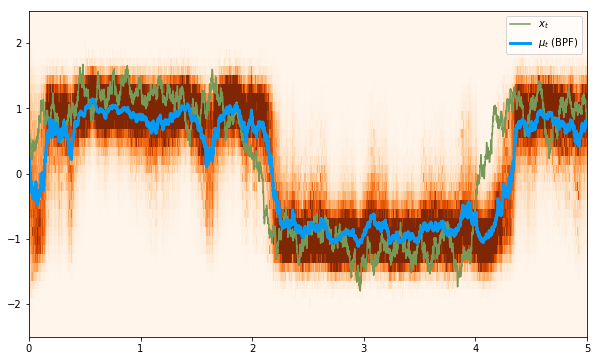

In [14]:
T = params["T"]*dt
plotrange = [0,T,-2.5,2.5]
t = np.arange(T/dt+1)*dt

fig, (ax2) = plt.subplots(1,1,figsize=(10,6))



hist = np.transpose(histImage(x_PF,int(np.sqrt(N)),(-3,3),w=w_PF))
ax2.imshow(np.flipud(hist), cmap='Oranges', interpolation='nearest', extent=[0,T,-3,3],aspect='auto',vmax=0.7)
ax2.plot(t,x,color='xkcd:moss')
ax2.plot(t,np.average(x_PF,1,w_PF), linewidth=3,color = 'xkcd:azure')
ax2.axis(plotrange)
ax2.legend(['hidden state','BPF'],fontsize=16)
ax2.legend([r'$x_t$',r'$\mu_t$ (BPF)'])

plt.show()

## Nonlinear filtering with Poisson noise
As an alternative to Gaussian-type observation noise, we consider here point-process observations, with the intensity $ g(x_t)$ being a function of the latent state $x_t$.
\begin{eqnarray}
y_t &\sim & Poisson(g(x_t)).
\end{eqnarray}
As a concrete example, we consider a Gaussian-shaped rate function $ g(x) = g_0 \exp(\frac{x-m_o}{2 s_0^2}) dt $ for two sensors with peaks at $ m_0 = \pm 1 $ and width $ s_0 $ (i.e. conditionally independent two-dimensional observations).
The hidden dynamics is the same as in the previous example. If you want to draw the link to neuroscience, you might consider those "sensors" to be two place cells that fire with a higher rate once the animal (the latent state) is close to their respective place fields. 

In [15]:
def NLPoisson_generateData(params):
    
    # unpack some parameters for readibility
    f = params["f"]
    g = params["g"]
    
    x = np.zeros(params["T"]+1)
    y = np.zeros((params["T"]+1,2))
    
    # initialization (draw from Gauss with mean mu0 and variance Sigma0)
    x[0] = np.random.normal(params["mu0"],np.sqrt(params["Sigma0"]))
    
    for t in range(1,params["T"]+1):
        x[t] = np.random.normal( f(x[t-1])  , np.sqrt(params["Q"]) )
        y[t] = np.random.poisson(g(x[t]))
    
    
    return x, y

In [16]:
np.random.seed(42)

N = 2000
c = 0.2
dt = 0.001
g0 = 50
s0 = 0.05
m0 = np.array([-1,1])

params = {
    "f": lambda x: x-4*x*(x**2-1)*dt,
    "Q": 2 * dt,
    "g": lambda x: g0 * np.transpose(np.exp( - np.array([x-m0[0],x-m0[1]])**2/(2 * s0**2) ))*dt,
    "mu0": 0,
    "Sigma0": 1,
    "T": int(5/dt),
}

x,y = NLPoisson_generateData(params)

Same as before, just code up the BPF. Careful: The weighting step requires a bit of thinking...

In [17]:
def NLPoisson_BPF(y,N,c,params):
    
    # unpack some parameters for readibility
    f = params["f"]
    g = params["g"]
    
    # initialization
    x = np.zeros([params["T"]+1,N])
    x[0] = np.random.normal(params["mu0"],np.sqrt(params["Sigma0"]),N)
    w = np.zeros([params["T"]+1,N])
    w[0] = 1/N
    
    # filtering recursion
    for t in range(1,params["T"]+1):
        # draw from proposal (transition density)
        x[t] = np.random.normal( f(x[t-1])  , np.sqrt(params["Q"]) , N )
        #compute weights
        w[t] = w[t-1] * np.prod(poisson.pmf(y[t], g(x[t])),1)
        w[t] = w[t] / np.sum(w[t])
        
        # resample if necessary
        Neff = 1/np.sum(w[t]**2)
        if Neff < c * N:
            x[t],w[t] = resample(x[t],w[t],N)
            
    return x, w

x_PF_PP,w_PF_PP = NLPoisson_BPF(y,N,c,params)

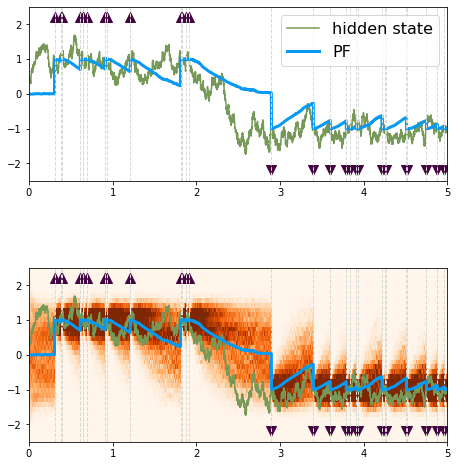

In [21]:
t_minus = np.where(y[:,0]>=1)[0]
t_plus = np.where(y[:,1]>=1)[0]
T = params["T"]*dt
t = np.arange(T/dt+1)*dt

plotrange = [0, T, -2.5, 2.5]

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7.5,8))
plt.subplots_adjust(hspace=0.5)

ax1.plot(t,x,color = 'xkcd:moss')
ax1.plot(t,np.average(x_PF_PP,1,w_PF_PP),color = 'xkcd:azure',linewidth=3)
for spikepos in t[np.where(y>=1)[0]]:
    ax1.axvline(x=spikepos,linestyle='--',color = 'xkcd:light grey',linewidth=1)
ax1.scatter(t[t_plus],2.2*np.ones(t_plus.size),marker="^",c='xkcd:eggplant purple',s=100)
ax1.scatter(t[t_minus],-2.2*np.ones(t_minus.size),marker="v",c='xkcd:eggplant purple',s=100)
ax1.axis(plotrange)
ax1.legend(['hidden state','PF'],fontsize=16)

hist = np.transpose(histImage(x_PF_PP,int(np.sqrt(N)),(-3,3),w=w_PF_PP))
ax2.imshow(np.flipud(hist), cmap='Oranges', interpolation='nearest', extent=[0,T,-3,3],aspect='auto',vmax=0.7)
for spikepos in t[np.where(y>=1)[0]]:
    ax2.axvline(x=spikepos,linestyle='--',color = 'xkcd:light grey',linewidth=1)
ax2.scatter(t[t_plus],2.2*np.ones(t_plus.size),marker="^",c='xkcd:eggplant purple',s=100)
ax2.scatter(t[t_minus],-2.2*np.ones(t_minus.size),marker="v",c='xkcd:eggplant purple',s=100)
ax2.plot(t,x,color='xkcd:moss')
ax2.plot(t,np.average(x_PF_PP,1,w_PF_PP), linewidth=3,color = 'xkcd:azure')
ax2.axis(plotrange)


plt.show()